# Step 1: Minimal CrossFormer Inference Example

This Colab demonstrates how to load a pre-trained / finetuned CrossFormer checkpoint, run inference for a single-arm and bimanual manipulation system, and compare the outputs to the true actions.

First, let's start with a minimal example!

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import jax
import tensorflow_datasets as tfds
import tqdm
import datasets
import itertools
from PIL import Image
import io
from crossformer.utils import visualization_utils

#import mediapy

In [77]:
from crossformer.model.crossformer_model import CrossFormerModel

model = CrossFormerModel.load_pretrained("hf://rail-berkeley/crossformer")

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

In [38]:
import os
import certifi
os.environ['SSL_CERT_FILE'] = certifi.where()
os.environ['CURL_CA_BUNDLE'] = certifi.where()

In [50]:
# create RLDS dataset builder
builder = tfds.builder_from_directory(
    builder_dir="gs://gresearch/robotics/bridge/0.1.0/"
)
ds = builder.as_dataset(split="train[:1]")

# sample episode and resize to 224x224 (default third-person cam resolution)
episode = next(iter(ds))
steps = list(episode["steps"])
images = [
    cv2.resize(np.array(step["observation"]["image"]), (224, 224)) for step in steps
]

# extract goal image and language instruction
goal_image = images[-1]
language_instruction = (
    steps[0]["observation"]["natural_language_instruction"].numpy().decode()
)

# visualize episode
print(f"Instruction: {language_instruction}")
#mediapy.show_video(images, fps=10)


2024-11-22 16:43:39.555982: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-22 16:43:39.557178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-22 16:43:39.663300: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 16:43:42.337091: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-22 16:43:44.766055: W external/local_tsl/tsl/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: C

Instruction: Place the can to the left of the pot.


In [70]:
print(f"Instruction: {language_instruction}")
print(goal_image.shape)

Instruction: Place the can to the left of the pot.
(224, 224, 3)


In [32]:
#OpenX-Embodiment dataset
dataset_names = ["kuka", "bc_z", "cmu_playing_with_food"]
#loaded_datasets = []
data_per_dataset = {}
for dataset_name in dataset_names:
    ds = datasets.load_dataset("jxu124/OpenX-Embodiment", dataset_name, streaming=True, split='train', trust_remote_code=True)  # IterDataset
    #loaded_datasets.append(ds)
    random_item = next(itertools.islice(ds, 10, 10 + 1))
    data_per_dataset[dataset_name] = random_item

In [98]:
def create_observation(data, WINDOW_SIZE=1):
    img = Image.open(io.BytesIO(data['data.pickle']['steps'][0]['observation']['image']['bytes']))
    img = img.resize((224,224))
    #display(img)
    img = np.asarray(img)
    input_images = np.stack(img)[None,None]
    observation = {
        "image_primary": input_images,
        "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
    }
    return observation

In [101]:
def create_language_task(instruction, model):
    #print(data['data.pickle']['steps'][0].keys())
    #language_instruction = data['data.pickle']['steps'][0]['language_instruction']
    task = model.create_tasks(texts=[instruction])  # for language conditioned
    return task

[154, 155, 156, 157]


[154, 155, 156, 157]


[154, 155, 156, 157]


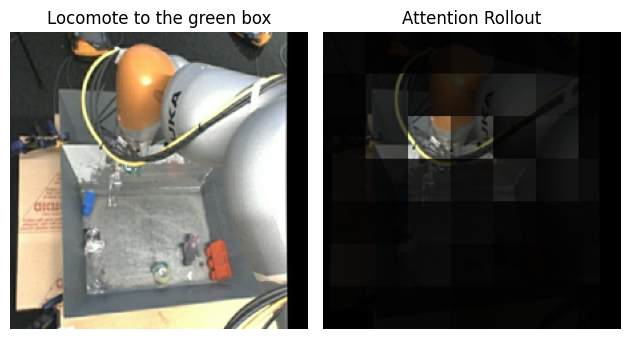

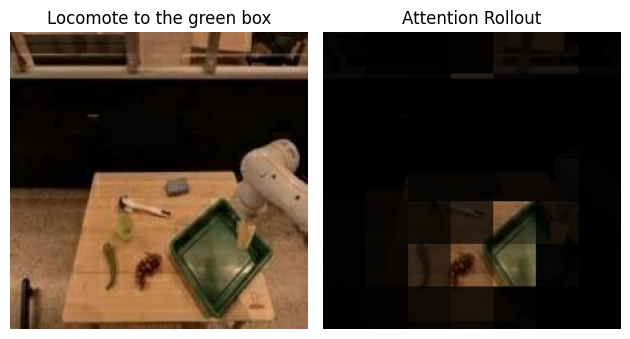

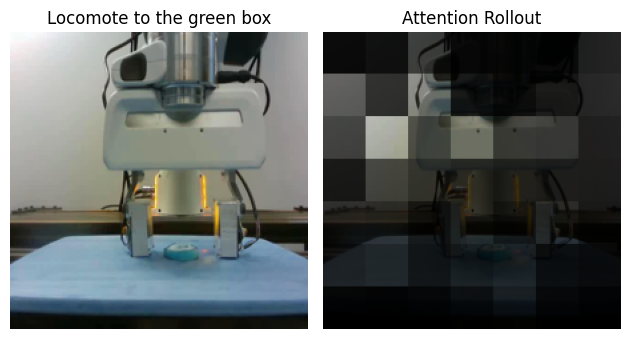

In [104]:
import importlib
importlib.reload(visualization_utils)
language_instruction = "Locomote to the green box"
for data in data_per_dataset.keys():
    observation = create_observation(data_per_dataset[data])
    task = create_language_task(language_instruction, model)
    rollout, token_types = model.analyze_attention(observation, task)
    fig = visualization_utils.plot_readout_attention(rollout, token_types, "readout_single_arm", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0], title=language_instruction)

In [ ]:
import importlib
importlib.reload(visualization_utils)
language_instruction = "Pick up the white brush"
for data in data_per_dataset.keys():
    observation = create_observation(data_per_dataset[data])
    task = create_language_task(language_instruction, model)
    rollout, token_types = model.analyze_attention(observation, task)
    fig = visualization_utils.plot_readout_attention(rollout, token_types, "readout_single_arm", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0], title=language_instruction)

In [ ]:
WINDOW_SIZE = 1

# create task dictionary
task = model.create_tasks(
    goals={"image_primary": goal_image[None]}
)  # for goal-conditioned
task = model.create_tasks(texts=[language_instruction])  # for language conditioned

In [ ]:
for step in tqdm.trange(len(images) - (WINDOW_SIZE - 1)):
input_images = np.stack(images[0 : 0 + WINDOW_SIZE])[None]
observation = {
    "image_primary": input_images,
    "timestep_pad_mask": np.full((1, input_images.shape[1]), True, dtype=bool),
}

In [ ]:
rollout, token_types = model.analyze_attention(observation, task)


In [ ]:
from crossformer.utils import visualization_utils
#import importlib
#importlib.reload(visualization_utils)
fig = visualization_utils.plot_readout_attention(rollout, token_types, "readout_nav", observation, observation_type="_primary", observation_image=observation["image_primary"][0,0])